# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.390454
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in* 



In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.892407 analytic: 3.051811, relative error: 2.681667e-02
numerical: 0.772099 analytic: 0.941960, relative error: 9.909894e-02
numerical: -2.961327 analytic: -3.233661, relative error: 4.396039e-02
numerical: -2.912538 analytic: -3.014471, relative error: 1.719809e-02
numerical: 0.541182 analytic: 0.539011, relative error: 2.009338e-03
numerical: -4.253180 analytic: -4.467927, relative error: 2.462376e-02
numerical: 2.209896 analytic: 2.524806, relative error: 6.651114e-02
numerical: -0.547200 analytic: -0.748348, relative error: 1.552609e-01
numerical: -0.598598 analytic: -0.656101, relative error: 4.582956e-02
numerical: 3.880569 analytic: 4.164541, relative error: 3.529749e-02
numerical: 1.083121 analytic: 1.205303, relative error: 5.339125e-02
numerical: 1.037775 analytic: 1.270908, relative error: 1.009806e-01
numerical: -4.892288 analytic: -5.375220, relative error: 4.703497e-02
numerical: 1.736476 analytic: 1.993352, relative error: 6.887081e-02
numerical: 2.599129 an

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.390454e+00 computed in 0.175780s
vectorized loss: 2.390454e+00 computed in 0.007108s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [5e-7, 3e-7, 2e-7, 1e-7, 0.5e-7, 5e-5, 3e-5, 1e-5, 5e-3, 3e-3, 1e-3]
regularization_strengths = [1e4, 2e4, 2.5e4, 3e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=1500, verbose=True)
        y_train_pred = softmax.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, rs)] = (train_acc, val_acc)
        
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 312.892052
iteration 100 / 1500: loss 43.019449
iteration 200 / 1500: loss 7.500851
iteration 300 / 1500: loss 2.818512
iteration 400 / 1500: loss 2.149225
iteration 500 / 1500: loss 2.078348
iteration 600 / 1500: loss 2.028447
iteration 700 / 1500: loss 2.136754
iteration 800 / 1500: loss 2.083705
iteration 900 / 1500: loss 2.137095
iteration 1000 / 1500: loss 2.034424
iteration 1100 / 1500: loss 2.163578
iteration 1200 / 1500: loss 2.114250
iteration 1300 / 1500: loss 2.053082
iteration 1400 / 1500: loss 2.000321
iteration 0 / 1500: loss 621.691181
iteration 100 / 1500: loss 12.865373
iteration 200 / 1500: loss 2.269343
iteration 300 / 1500: loss 2.092051
iteration 400 / 1500: loss 2.147766
iteration 500 / 1500: loss 2.042118
iteration 600 / 1500: loss 2.113420
iteration 700 / 1500: loss 2.139546
iteration 800 / 1500: loss 2.122430
iteration 900 / 1500: loss 2.092609
iteration 1000 / 1500: loss 2.027169
iteration 1100 / 1500: loss 2.165695
iteration 1200 / 15

iteration 0 / 1500: loss 310.765330
iteration 100 / 1500: loss 207.117468
iteration 200 / 1500: loss 139.124783
iteration 300 / 1500: loss 93.808153
iteration 400 / 1500: loss 63.491774
iteration 500 / 1500: loss 42.950814
iteration 600 / 1500: loss 29.491727
iteration 700 / 1500: loss 20.394881
iteration 800 / 1500: loss 14.277776
iteration 900 / 1500: loss 10.247158
iteration 1000 / 1500: loss 7.602555
iteration 1100 / 1500: loss 5.867529
iteration 1200 / 1500: loss 4.510408
iteration 1300 / 1500: loss 3.627141
iteration 1400 / 1500: loss 3.316331
iteration 0 / 1500: loss 626.645684
iteration 100 / 1500: loss 280.948676
iteration 200 / 1500: loss 126.826653
iteration 300 / 1500: loss 57.854308
iteration 400 / 1500: loss 27.110580
iteration 500 / 1500: loss 13.334326
iteration 600 / 1500: loss 7.093504
iteration 700 / 1500: loss 4.388699
iteration 800 / 1500: loss 3.091857
iteration 900 / 1500: loss 2.649202
iteration 1000 / 1500: loss 2.291196
iteration 1100 / 1500: loss 2.243641
ite

/Users/nikitaokorokov/Documents/Education/Online courses/CS231n Convolutional Neural Networks for Visual Recognition/assignment1/cs231n/classifiers/softmax.py:88: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(yi_scores))


iteration 100 / 1500: loss inf
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf
iteration 700 / 1500: loss inf
iteration 800 / 1500: loss inf
iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 769.638856
iteration 100 / 1500: loss inf
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf
iteration 700 / 1500: loss inf
iteration 800 / 1500: loss inf


/Users/nikitaokorokov/Documents/Education/Online courses/CS231n Convolutional Neural Networks for Visual Recognition/assignment1/cs231n/classifiers/softmax.py:96: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/Users/nikitaokorokov/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/nikitaokorokov/Documents/Education/Online courses/CS231n Convolutional Neural Networks for Visual Recognition/assignment1/cs231n/classifiers/softmax.py:96: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 932.026812
iteration 100 / 1500: loss inf
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf
iteration 700 / 1500: loss inf
iteration 800 / 1500: loss inf
iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf


/Users/nikitaokorokov/Documents/Education/Online courses/CS231n Convolutional Neural Networks for Visual Recognition/assignment1/cs231n/classifiers/softmax.py:83: RuntimeWarning: overflow encountered in subtract
  scores = scores - np.max(scores, axis = 1, keepdims = True)
/Users/nikitaokorokov/Documents/Education/Online courses/CS231n Convolutional Neural Networks for Visual Recognition/assignment1/cs231n/classifiers/softmax.py:97: RuntimeWarning: overflow encountered in multiply
  dW += 2*reg*W


iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 1527.031140
iteration 100 / 1500: loss inf
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 313.716726
iteration 100 / 1500: loss 25.987261
iteration 200 / 1500: loss 27.137918
iteration 300 / 1500: loss 23.990264
iteration 400 / 1500: loss 18.935660
iteration 500 / 1500: loss 24.324875
iteration 600 / 1500: loss 16.231685
iteration 700 / 1500: loss 20.197294
iteration 800 / 1500: loss 25.104758
iteration 900 / 1500: loss 21.056445
iteration 1000 / 1500: loss

/Users/nikitaokorokov/Documents/Education/Online courses/CS231n Convolutional Neural Networks for Visual Recognition/assignment1/cs231n/classifiers/softmax.py:83: RuntimeWarning: invalid value encountered in subtract
  scores = scores - np.max(scores, axis = 1, keepdims = True)


iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 628.036384
iteration 100 / 1500: loss inf
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 778.166519
iteration 100 / 1500: loss inf
iteration 200 / 1500: loss nan
iteration 300 / 150

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.363000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



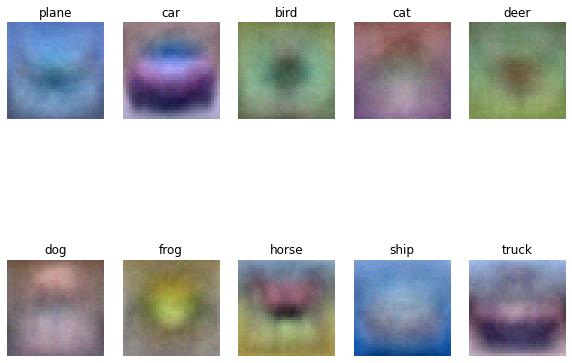

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])